**Christian Gauthier Coursework**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data_na.csv')

# Drop Rows with NaN Values inplace
df.dropna(inplace=True) 
df.sample

<bound method NDFrame.sample of      X0    X1      X2      X3      X4    X5    X6    X7    X8      Y
1    C1  1.19  622.55  323.40  109.15  7.70  3.00  0.00  0.00  15.55
2    C1  0.88  463.05  291.06   99.23  5.67  4.40  0.00  0.00  15.55
3    C2  0.79  509.36  291.06  121.28  6.30  4.05  0.00  0.00  15.55
4    C1  0.89  507.15  385.39  121.28  7.70  2.00  0.00  0.00  20.84
5    C1  0.89  456.44  257.98  134.75  8.47  2.43  0.00  0.00  21.46
..   ..   ...     ...     ...     ...   ...   ...   ...   ...    ...
762  C1  0.64  948.64  339.57  242.55  3.47  3.24  0.44  4.95  18.16
763  C3  0.52  948.64  277.83  218.30  4.24  4.95  0.48  4.05  17.88
765  C1  0.68  889.35  404.25  178.60  3.47  2.43  0.40  4.95  16.44
766  C3  0.50  654.88  363.82  218.30  3.15  3.96  0.36  4.50  16.48
767  C3  0.50  800.42  404.25  218.30  2.84  4.05  0.32  4.95  16.64

[728 rows x 10 columns]>

<AxesSubplot: >

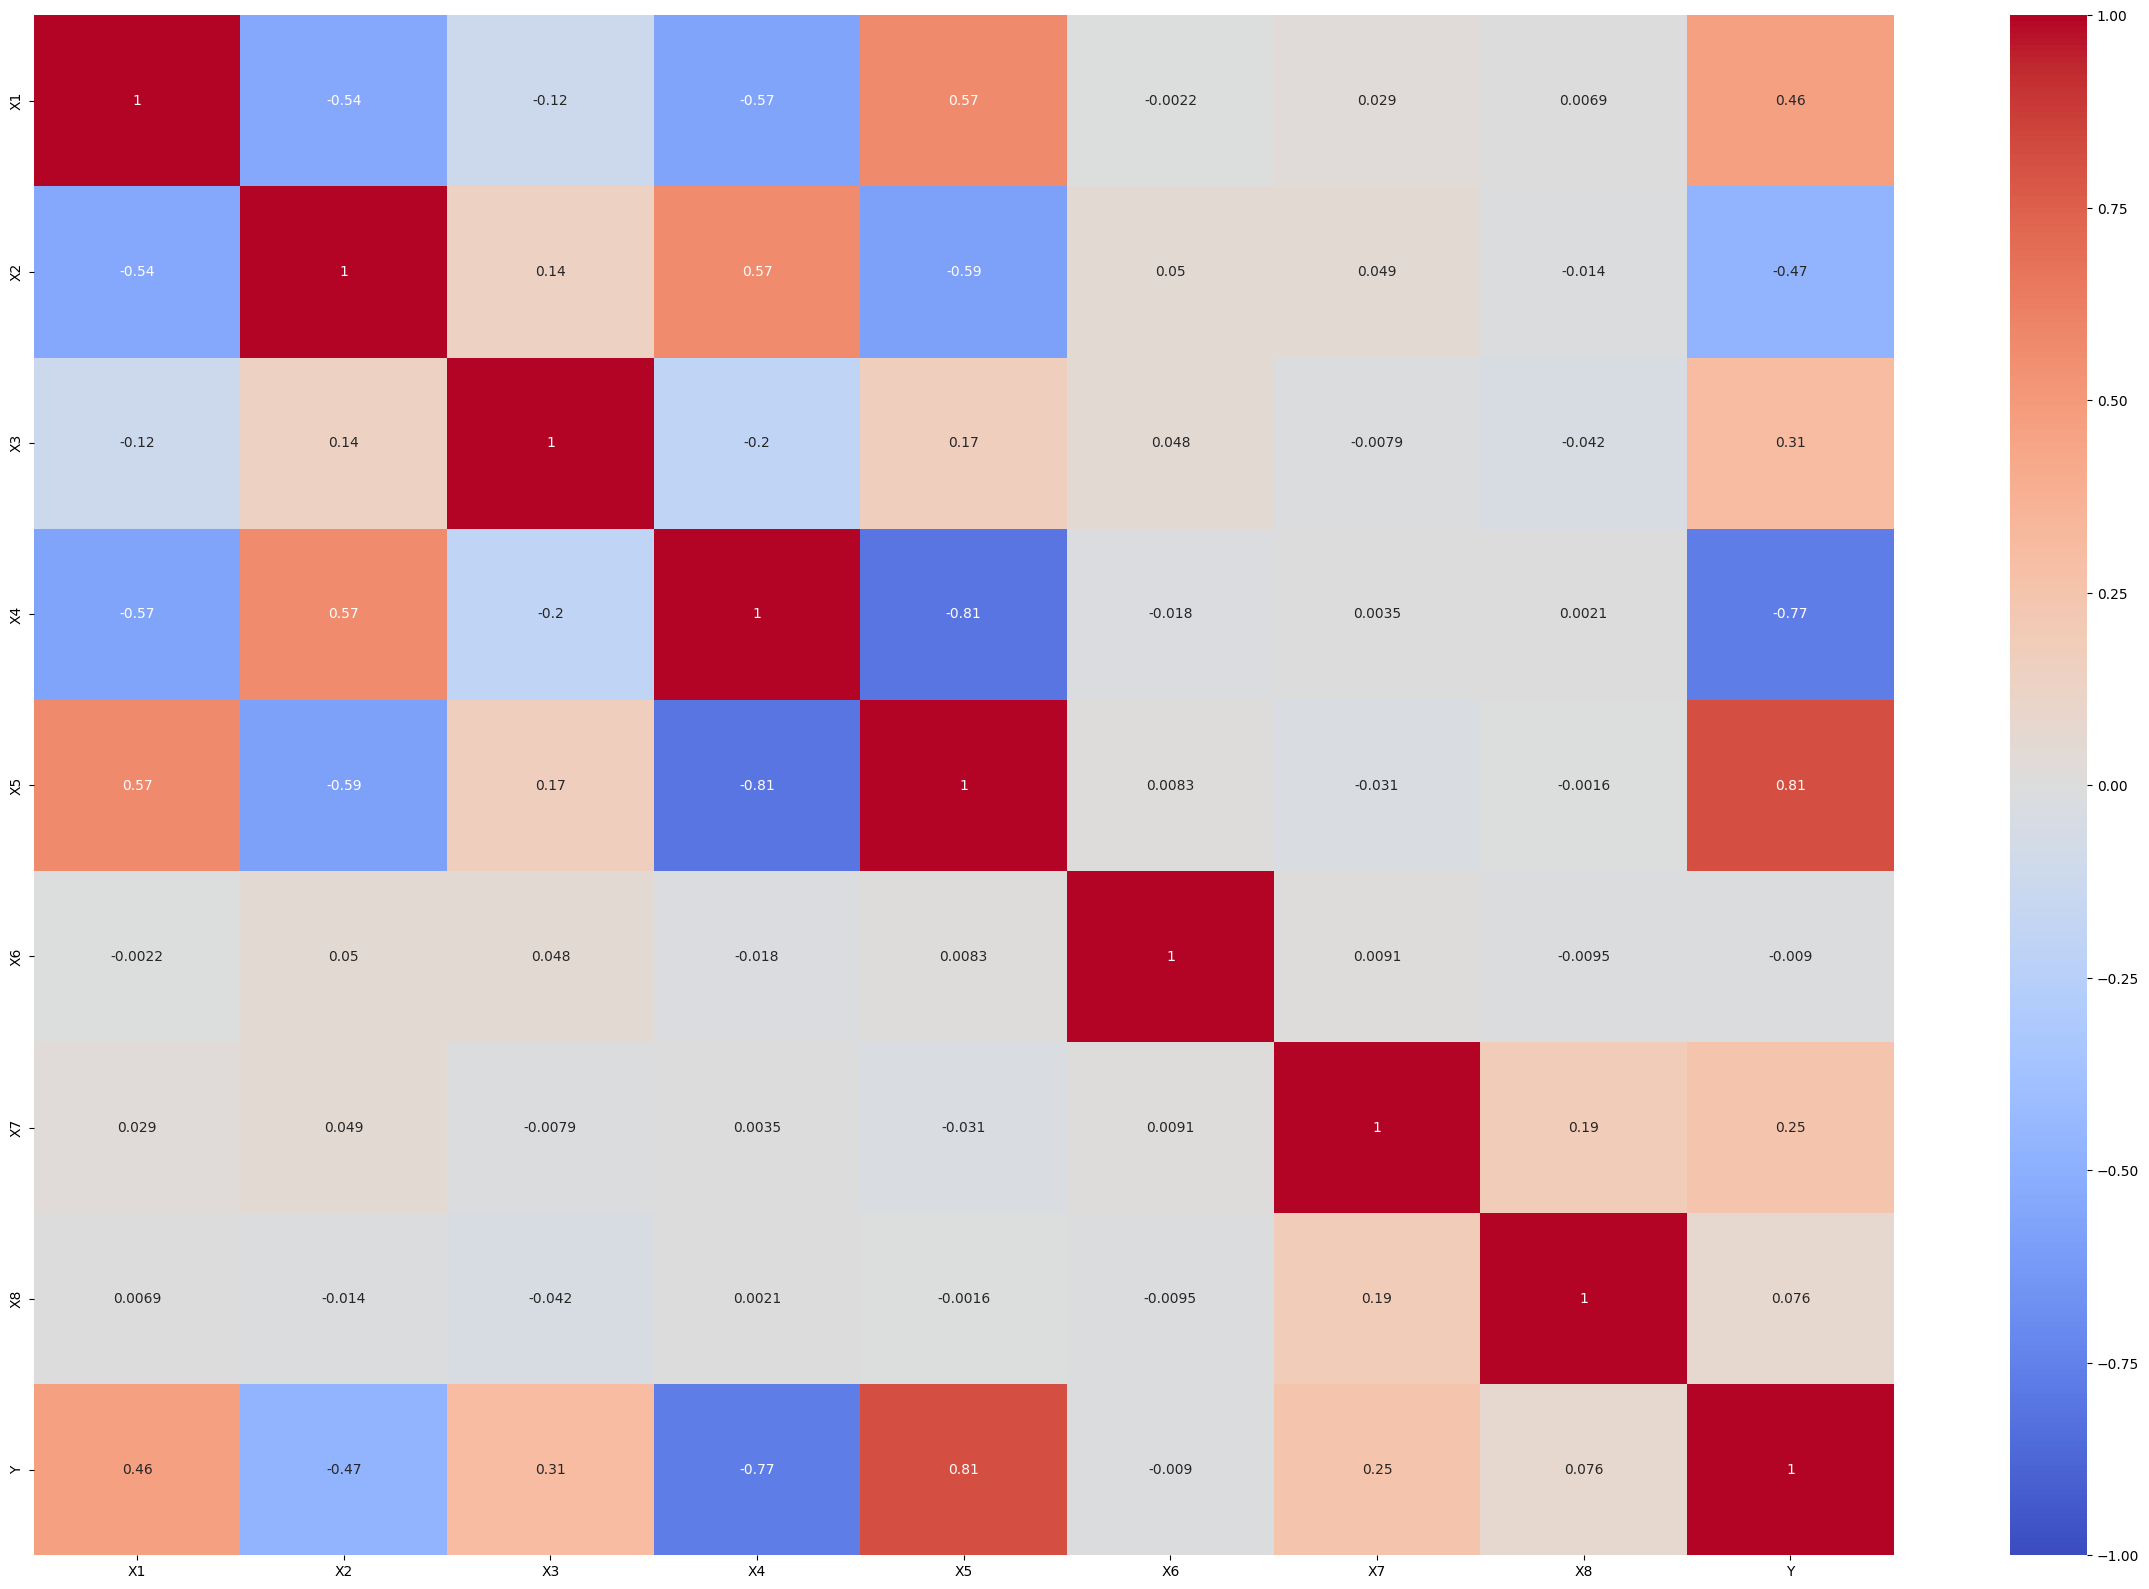

In [2]:
df.describe() #return a description of the dataframe 

plt.figure(figsize=(30,20)) #create figure
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap="coolwarm",annot=True) #show the data as a heatmap

*Heatmap*

From the heatmap can see what variables have the strongest link towards the output Y
In the order of importance; x5,x4,x2,x1,x3,x7,x8,x6

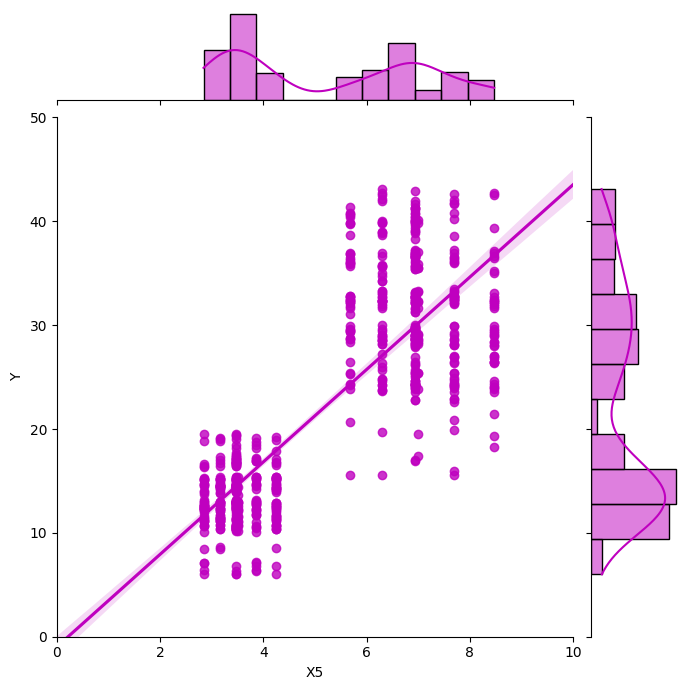

In [3]:
g = sns.jointplot(x="X5", y="Y", data=df,
                  kind="reg", truncate=False,
                  xlim=(0, 10), ylim=(0, 50),
                  color="m", height=7)

In [4]:
labels = df["Y"].copy()
predictors = df.iloc[:, :-1]

In [5]:
print(predictors.iloc[:,1:])

       X1      X2      X3      X4    X5    X6    X7    X8
1    1.19  622.55  323.40  109.15  7.70  3.00  0.00  0.00
2    0.88  463.05  291.06   99.23  5.67  4.40  0.00  0.00
3    0.79  509.36  291.06  121.28  6.30  4.05  0.00  0.00
4    0.89  507.15  385.39  121.28  7.70  2.00  0.00  0.00
5    0.89  456.44  257.98  134.75  8.47  2.43  0.00  0.00
..    ...     ...     ...     ...   ...   ...   ...   ...
762  0.64  948.64  339.57  242.55  3.47  3.24  0.44  4.95
763  0.52  948.64  277.83  218.30  4.24  4.95  0.48  4.05
765  0.68  889.35  404.25  178.60  3.47  2.43  0.40  4.95
766  0.50  654.88  363.82  218.30  3.15  3.96  0.36  4.50
767  0.50  800.42  404.25  218.30  2.84  4.05  0.32  4.95

[728 rows x 8 columns]


In [6]:
#Split the dataset into chunks train/test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(predictors, labels, test_size=0.3, shuffle=False)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(509, 9)
(219, 9)
(509,)
(219,)


In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

numeric_features = ['X1','X2','X3','X4','X5','X6','X7','X8']
numeric_transformer = Pipeline([
    ('std_scaler', StandardScaler())
])

categorical_features = ['X0']
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [8]:
scaler = StandardScaler()
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(509, 11)
(219, 11)
(509, 1)
(219, 1)


*Linear Regression*

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from numpy import mean,std,absolute

# define model evaluation method
lin_reg = LinearRegression()
cv = RepeatedKFold(n_splits=3, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(lin_reg, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.345 (0.011)


*Elastic Net*

In [11]:
from sklearn.linear_model import ElasticNet

el = ElasticNet(alpha=0.01, l1_ratio=0.95)
# evaluate model
scores = cross_val_score(el, x_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean MAE: 0.344 (0.013)


In [12]:
el.fit(x_train,y_train)

preds = el.predict(x_test)
el_mse = mean_squared_error(y_test,preds)

In [13]:
print(el_mse)

0.26770005203991154


*Dense NN*

In [14]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import models
from tensorflow.keras import layers

In [81]:
def build_model(): 
    model=models.Sequential()
    model.add(layers.Dense(8, activation='tanh', 
              input_shape=(x_train.shape[1],), kernel_regularizer=regularizers.L1(0.01)))
    model.add(layers.Dense(1)) 
    opt = keras.optimizers.RMSprop(learning_rate=0.02, momentum=0.01)
    model.compile(
        optimizer=opt,
        loss='mse',
        metrics=['mae']
    )
    return model

In [82]:
K = 4
num_val_samples = len(x_train) // K
num_epochs = 200
all_scores = []
all_mae_histories = []

for i in range(K):
    print('processing fold', i)
    
    # Prepare the validation data: data from partition i
    a, b = i * num_val_samples, (i + 1) * num_val_samples
    val_data = x_train[a : b]
    val_targets = y_train[a : b]
    
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate([x_train[:a], x_train[b:]], axis=0)
    partial_train_targets = np.concatenate([y_train[:a], y_train[b:]], axis=0)

    model = build_model()
    
    
    # Evaluate fold
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    
    history = model.fit(partial_train_data, partial_train_targets,
                        epochs=num_epochs, batch_size=32, verbose=0,
                        validation_data=(val_data, val_targets))  
                        
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold 0
processing fold 1
processing fold 2
processing fold 3


In [83]:
print(all_scores)
print(np.mean(all_scores))

[0.91273432970047, 0.8847638368606567, 1.3321213722229004, 1.4076876640319824]
1.1343268007040024


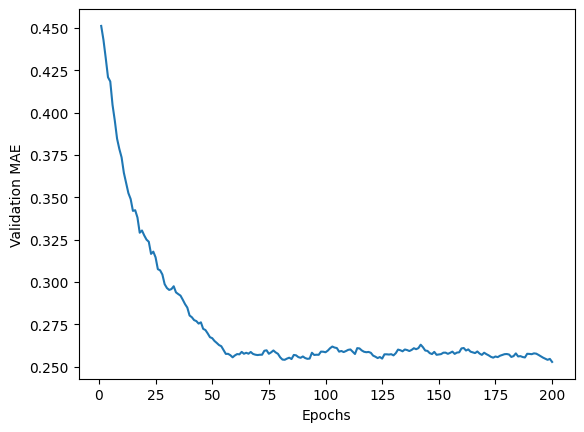

Early Stop Epoch: 199


In [84]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points: # an empty list is 'False'
            previous = smoothed_points[-1] # the last appended point
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

average_mae_history = [np.mean([x[i] for x in all_mae_histories])for i in range(num_epochs)]
smooth_mae_history = smooth_curve(mae_history) 
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print("Early Stop Epoch:", np.argmin(smooth_mae_history))

In [85]:
model = build_model()
model.fit(x_train, y_train, epochs = np.argmin(smooth_mae_history), batch_size = 100, verbose=0)

In [86]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.2414 - mae: 0.3423


In [87]:
print(test_mae_score)

0.34228700399398804


In [88]:
bingbong = model.predict(x_test)

7/7 [==============================] - 0s 2ms/step


In [89]:
import random

preds =  scaler.inverse_transform(bingbong)
y_inversed = scaler.inverse_transform(y_test)

for i in range(10):
    num = random.randint(1, 200)
    print("Real: ", y_inversed[i], "Predicted:", preds[i])


#print(preds[100])
#print(y_inversed[100])

print(np.sum(np.abs(y_inversed-preds)))

Real:  [31.89] Predicted: [32.443207]
Real:  [32.39] Predicted: [30.158684]
Real:  [32.09] Predicted: [31.025265]
Real:  [31.29] Predicted: [31.175426]
Real:  [29.22] Predicted: [33.366394]
Real:  [29.91] Predicted: [32.889835]
Real:  [29.53] Predicted: [30.874863]
Real:  [28.65] Predicted: [31.526358]
Real:  [41.4] Predicted: [30.206425]
Real:  [42.62] Predicted: [33.70948]
728.589169960022
